In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

np.random.seed(1)         # set a seed so that the results are consistent

In [2]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral)
    

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

In [3]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4 # 硬编码为4
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.random.randn(n_h,1)
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.random.randn(n_y,1)
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

def new_nn_model(X, Y, n_h, num_iterations = 10000, lrt = 0.5, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    lrt -- learning_rate
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters,grads,lrt)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X,parameters)
    predictions = np.round(A2)
    
    return predictions


shape_X =  (2, 400)
shape_Y = (1, 400)
training examples =  400
Cost after iteration 0: 0.693150
Cost after iteration 1000: 0.311779
Cost after iteration 2000: 0.291045
Cost after iteration 3000: 0.282538
Cost after iteration 4000: 0.277048
Cost after iteration 5000: 0.272991
Cost after iteration 6000: 0.269807
Cost after iteration 7000: 0.267225
Cost after iteration 8000: 0.265085
Cost after iteration 9000: 0.263285
Accuracy: 90%


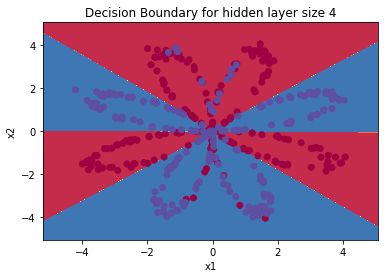

In [4]:
X, Y = load_planar_dataset()
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c = np.squeeze(Y), s=40, cmap=plt.cm.Spectral);
print("shape_X = ",X.shape)
print("shape_Y =", Y.shape)
print("training examples = ",X.shape[1])

# Train the logistic regression classifier
# clf = sklearn.linear_model.LogisticRegressionCV();
# clf.fit(X.T, Y.T);
# plot_decision_boundary(lambda x: clf.predict(x), X, Y) #绘制决策边界
# plt.title("Logistic Regression") #图标题
# LR_predictions  = clf.predict(X.T) #预测结果
# print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
#         np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
#        "% " + "(正确标记的数据点所占的百分比)")

# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')


Accuracy for 1 hidden units: 61.25000000000001 %
Accuracy for 2 hidden units: 65.5 %
Accuracy for 3 hidden units: 89.5 %
Accuracy for 4 hidden units: 89.5 %
Accuracy for 5 hidden units: 89.0 %
Accuracy for 20 hidden units: 90.25 %
Accuracy for 50 hidden units: 89.5 %
学习率为： 0.1  ，准确率: 88.0 %
学习率为： 0.2  ，准确率: 89.5 %
学习率为： 0.3  ，准确率: 89.5 %
学习率为： 0.4  ，准确率: 89.5 %
学习率为： 0.5  ，准确率: 89.5 %
学习率为： 0.6  ，准确率: 89.75 %
学习率为： 0.7  ，准确率: 89.75 %
学习率为： 0.8  ，准确率: 89.75 %
学习率为： 0.9  ，准确率: 90.5 %


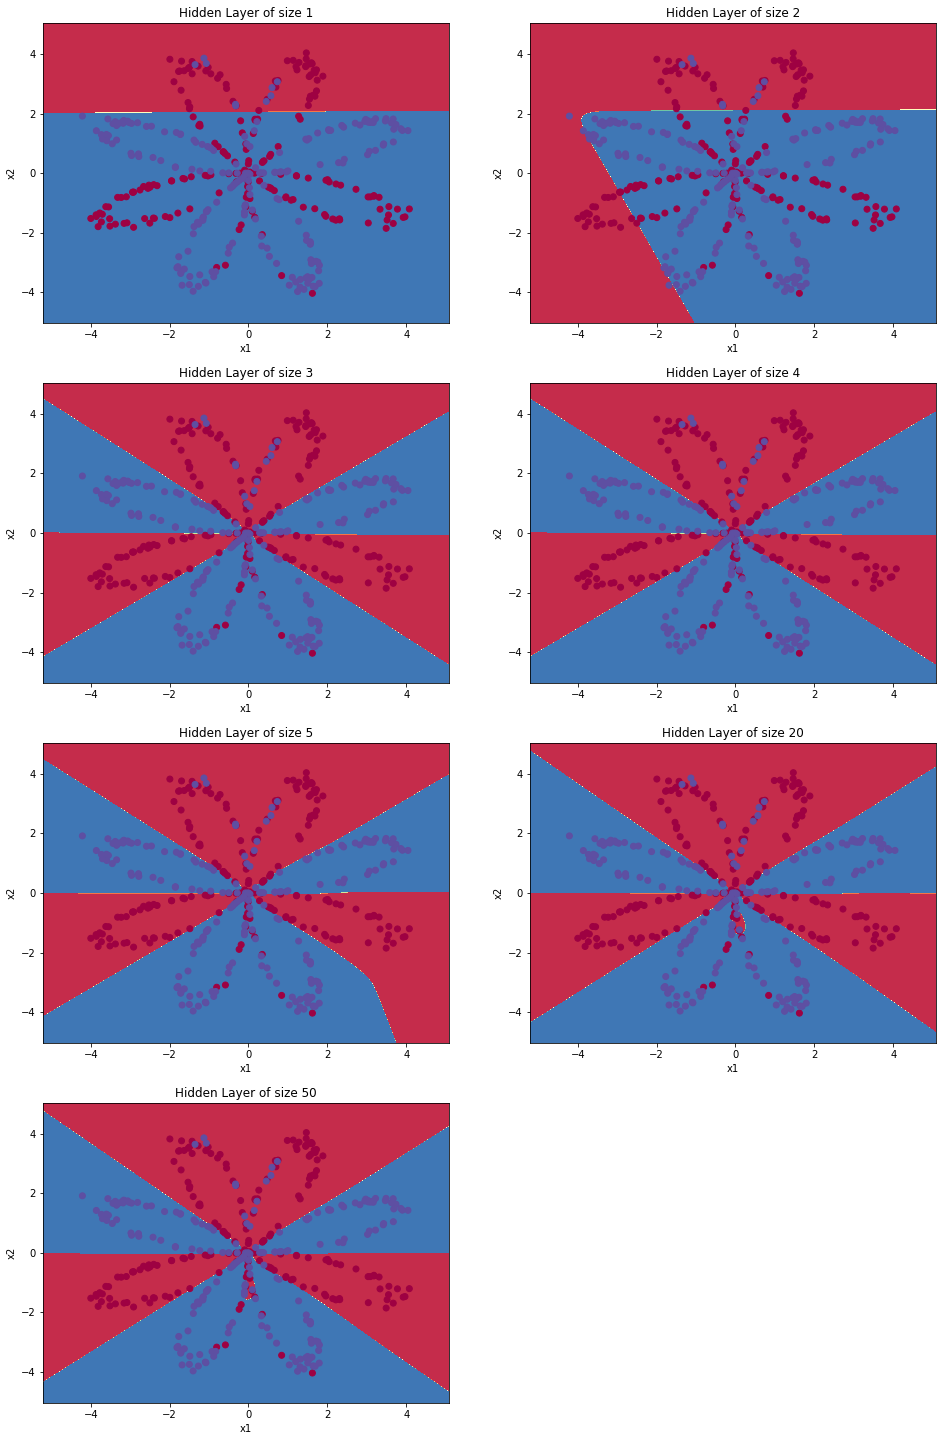

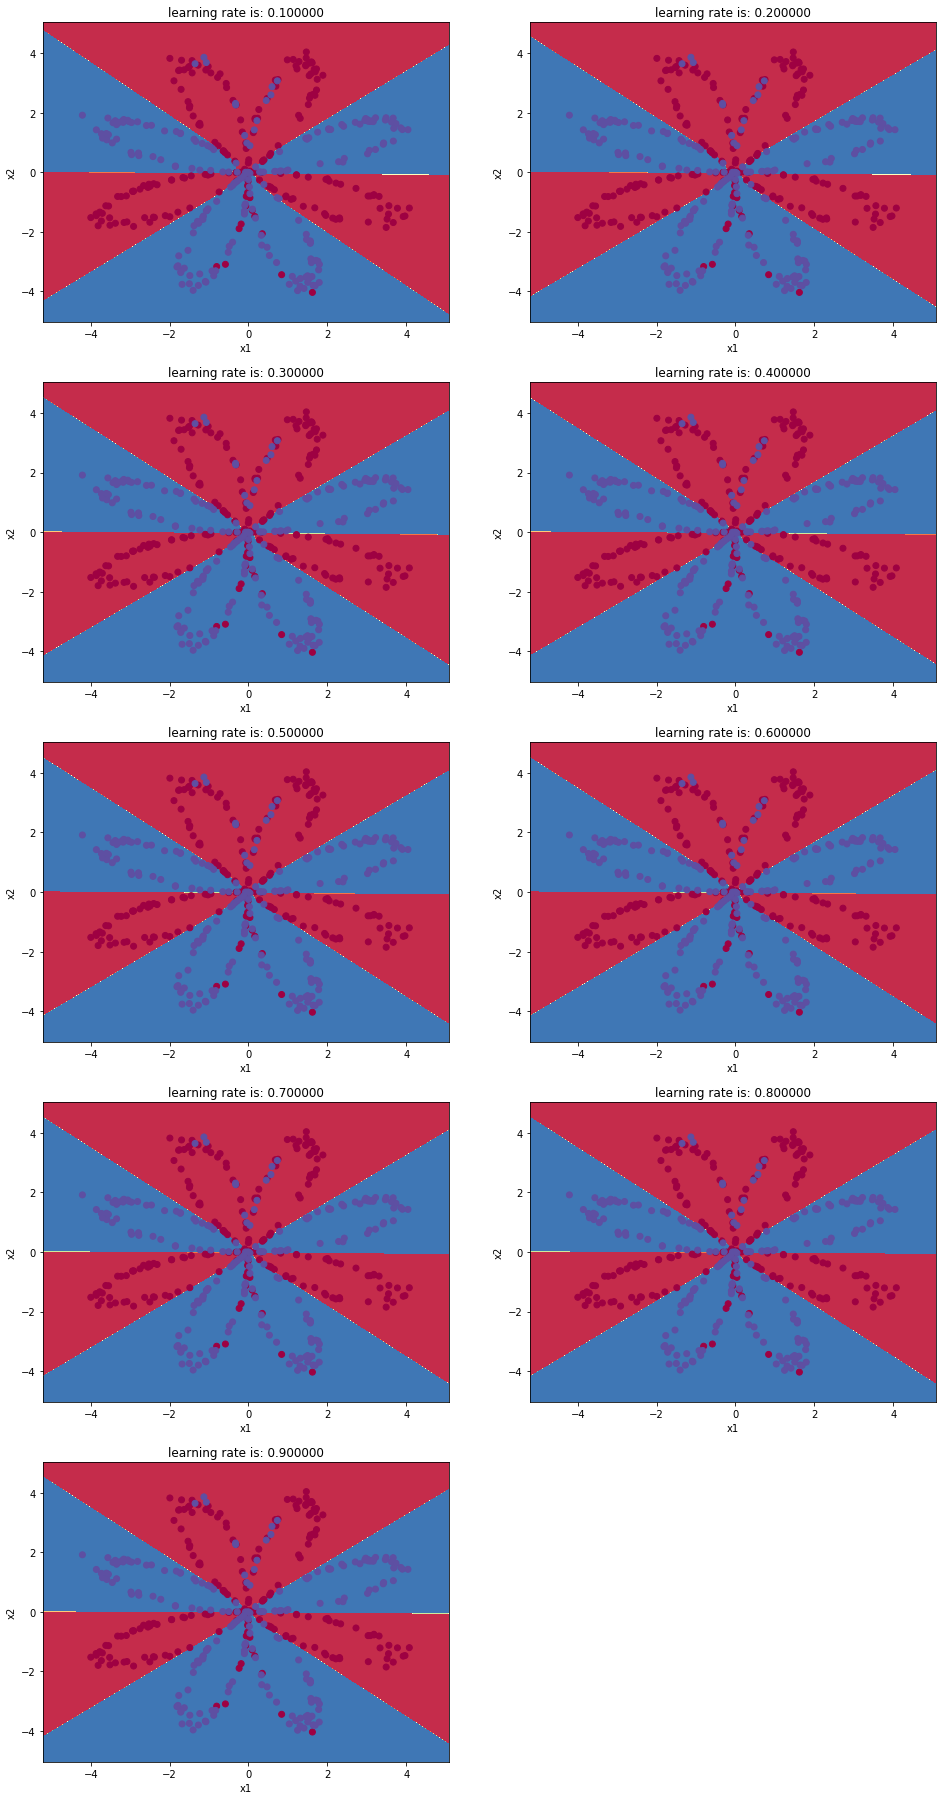

In [5]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))
    
plt.figure(figsize=(16, 32))
lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #更改隐藏层数量
for i, lr in enumerate(lrs):
    plt.subplot(5, 2, i + 1)
    plt.title('learning rate is: %f' % lr)
    parameters = new_nn_model(X, Y, n_h = 4,num_iterations=5000,lrt = lr)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("学习率为： {}  ，准确率: {} %".format(lr, accuracy))


(array([[-4.21407962e-01,  1.16462149e+00],
       [ 1.42603005e+00, -1.62536927e-02],
       [ 5.56090320e-01,  7.80595342e-01],
       [-1.46220385e-01,  2.50812375e-01],
       [ 8.32868552e-01,  6.20501407e-01],
       [ 8.83548567e-01,  1.83190214e-01],
       [ 1.65145144e+00,  1.93694207e-01],
       [ 3.49020366e-01, -3.66867930e-01],
       [-1.13823170e+00,  5.14088005e-01],
       [-1.96919907e-01,  1.13752342e+00],
       [ 3.65529559e-01,  6.31984074e-01],
       [ 4.02566673e-02,  5.45900409e-01],
       [ 1.01596058e+00,  7.33368659e-01],
       [-1.11338251e+00,  2.13830006e-01],
       [ 8.14195426e-03,  1.13046722e+00],
       [ 9.76206112e-01, -2.87467571e-01],
       [ 8.32786247e-01,  5.26139597e-01],
       [-8.17095823e-01,  3.42296625e-01],
       [ 9.35745909e-01,  3.67878100e-01],
       [ 7.03803813e-01,  4.39690452e-01],
       [-5.23056526e-01,  7.71356715e-01],
       [ 8.06826517e-02, -3.74714874e-01],
       [ 1.32304315e+00, -3.13216803e-01],
       [ 1

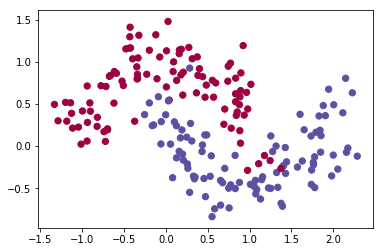

In [12]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"
X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral);


Accuracy for 1 hidden units: 85.0 %
Accuracy for 2 hidden units: 86.5 %
Accuracy for 3 hidden units: 95.5 %
Accuracy for 4 hidden units: 95.5 %
Accuracy for 5 hidden units: 95.5 %
Accuracy for 10 hidden units: 95.5 %
Accuracy for 20 hidden units: 95.5 %


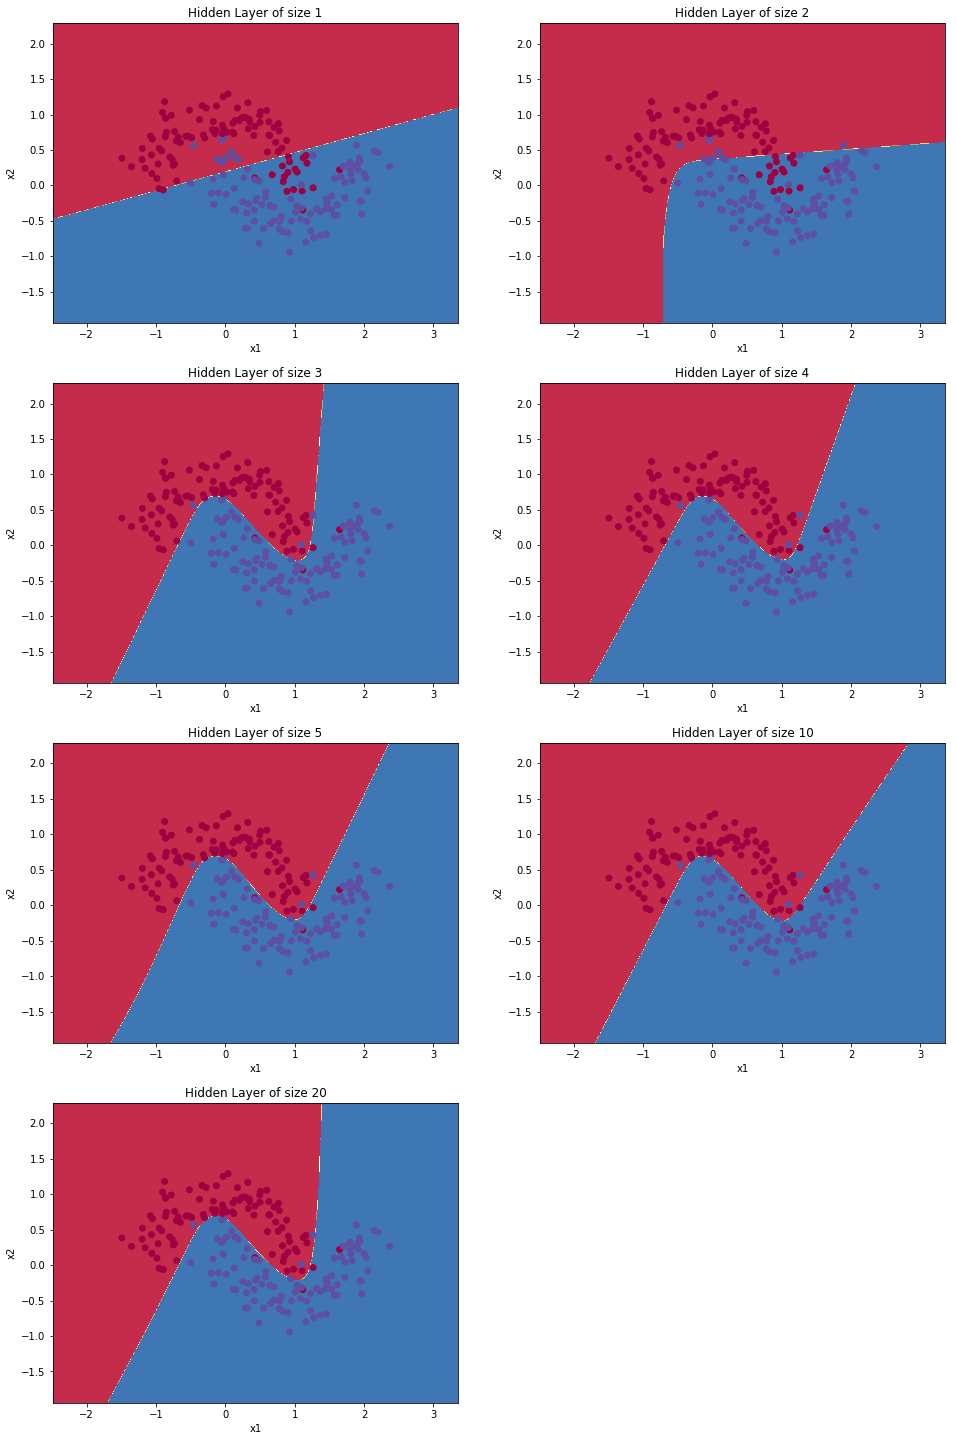

In [8]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))
    